In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.ets import AutoETS
from sktime.utils.plotting import plot_series

from sklearn.feature_extraction.text import TfidfVectorizer

from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.stattools import grangercausalitytests

import warnings

In [27]:
df = pd.read_csv('../data/EDA_df.csv', parse_dates = True)

In [10]:
df.head()

,productivity,gnp,unemployment,core_inflation,inflation,gdp,gdp_potential,interest_rate,report,sentiment
1970-05-20,6.215385,5055.766932,4.861290,7.111779,5.249699,1077.435615,5005.800307,7.95,This initial report of economic conditions in ...,-0.684800
1970-05-21,6.219780,5056.224370,4.864516,7.118406,5.245465,1077.640934,5006.230802,7.95,This initial report of economic conditions in ...,-0.644979
1970-05-22,6.224176,5056.681808,4.867742,7.125034,5.241231,1077.846253,5006.661297,7.95,This initial report of economic conditions in ...,-0.605157
1970-05-23,6.228571,5057.139247,4.870968,7.131661,5.236997,1078.051571,5007.091792,7.95,This initial report of economic conditions in ...,-0.565336
1970-05-24,6.232967,5057.596685,4.874194,7.138288,5.232763,1078.256890,5007.522287,7.95,This initial report of economic conditions in ...,-0.525514


https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/

In [11]:
numeric_df = df.drop(columns = ['report'])

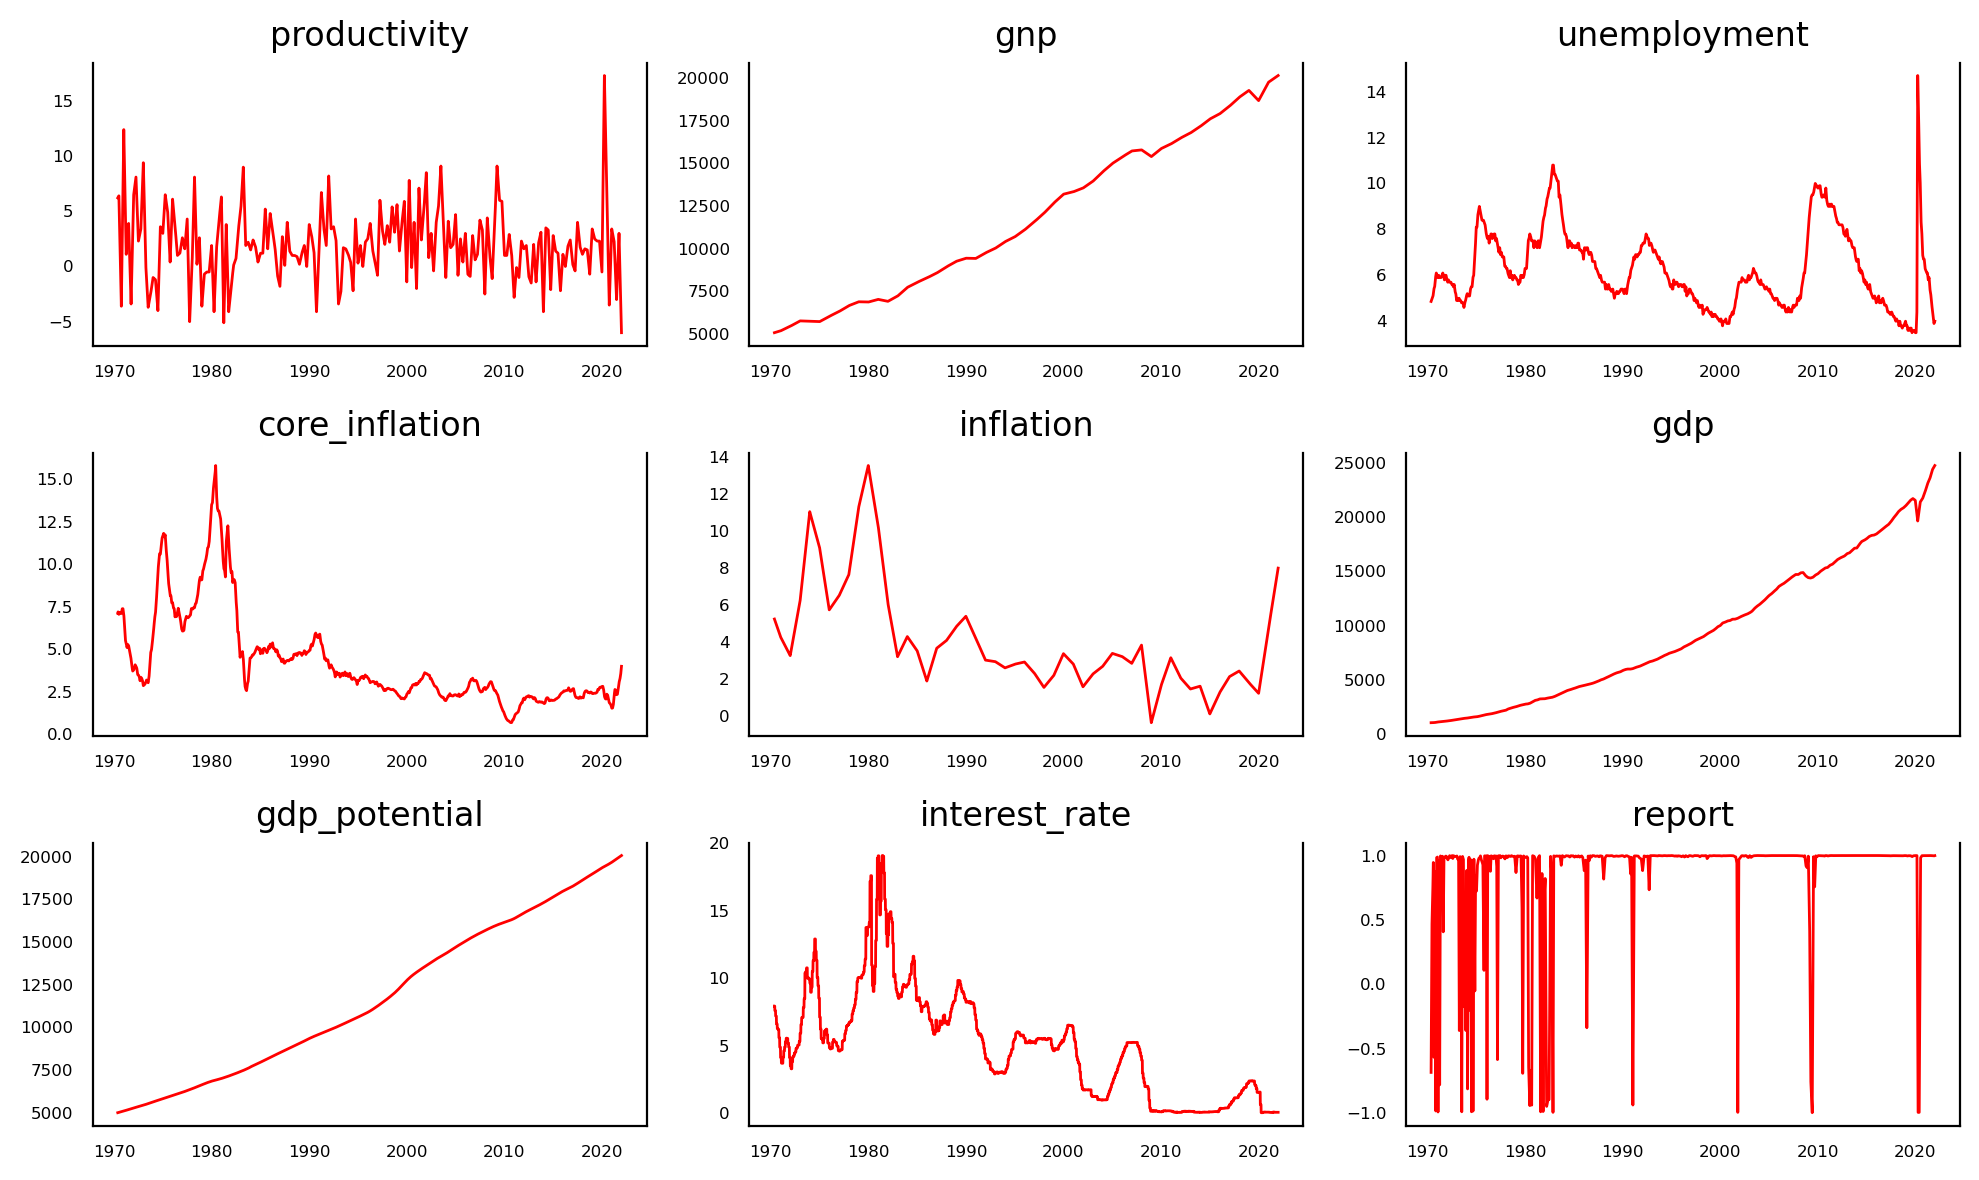

In [12]:
# via https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/
fig, axes = plt.subplots(nrows = 3, ncols = 3, dpi = 200, figsize = (10,6))
for i, ax in enumerate(axes.flatten()):
    data = numeric_df[numeric_df.columns[i]]
    ax.plot(data, color = 'red', linewidth = 1)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize = 6)

plt.tight_layout();

I'm going to conduct a Granger Causation test in order to get an idea of the correlation and causation between the variables present here. Since I will be conducting a Vector Autogregression, it is critical to understand the relationships present between the variables.

In [13]:
# via https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/
warnings.simplefilter(action = 'ignore', category = FutureWarning)

maxlag = 5
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test = 'ssr_chi2test', verbose = False):    
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag = maxlag, verbose = False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation = grangers_causation_matrix(numeric_df, variables = numeric_df.columns)     
warnings.resetwarnings()

In [14]:
grangers_causation

,productivity_x,gnp_x,unemployment_x,core_inflation_x,inflation_x,gdp_x,gdp_potential_x,interest_rate_x,sentiment_x
productivity_y,1.0000,0.0380,0.000,0.0000,0.0022,0.0399,0.2185,0.0,0.2785
gnp_y,0.0000,1.0000,0.000,0.0000,0.0000,0.0000,0.0000,0.0,0.0002
unemployment_y,0.0000,0.0006,1.000,0.0000,0.0203,0.0000,0.0014,0.0,0.0000
core_inflation_y,0.0000,0.0000,0.000,1.0000,0.0000,0.0000,0.0000,0.0,0.0000
inflation_y,0.0000,0.0000,0.000,0.0000,1.0000,0.0000,0.0000,0.0,0.0000
gdp_y,0.0000,0.0000,0.000,0.1869,0.0000,1.0000,0.0000,0.0,0.0000
gdp_potential_y,0.0000,0.0000,0.000,0.0000,0.0000,0.0000,1.0000,0.0,0.0000
interest_rate_y,0.0415,0.0566,0.001,0.0743,0.0000,0.0099,0.0298,1.0,0.0003
sentiment_y,0.2508,0.0000,0.000,0.0000,0.0000,0.0001,0.0000,0.0,1.0000


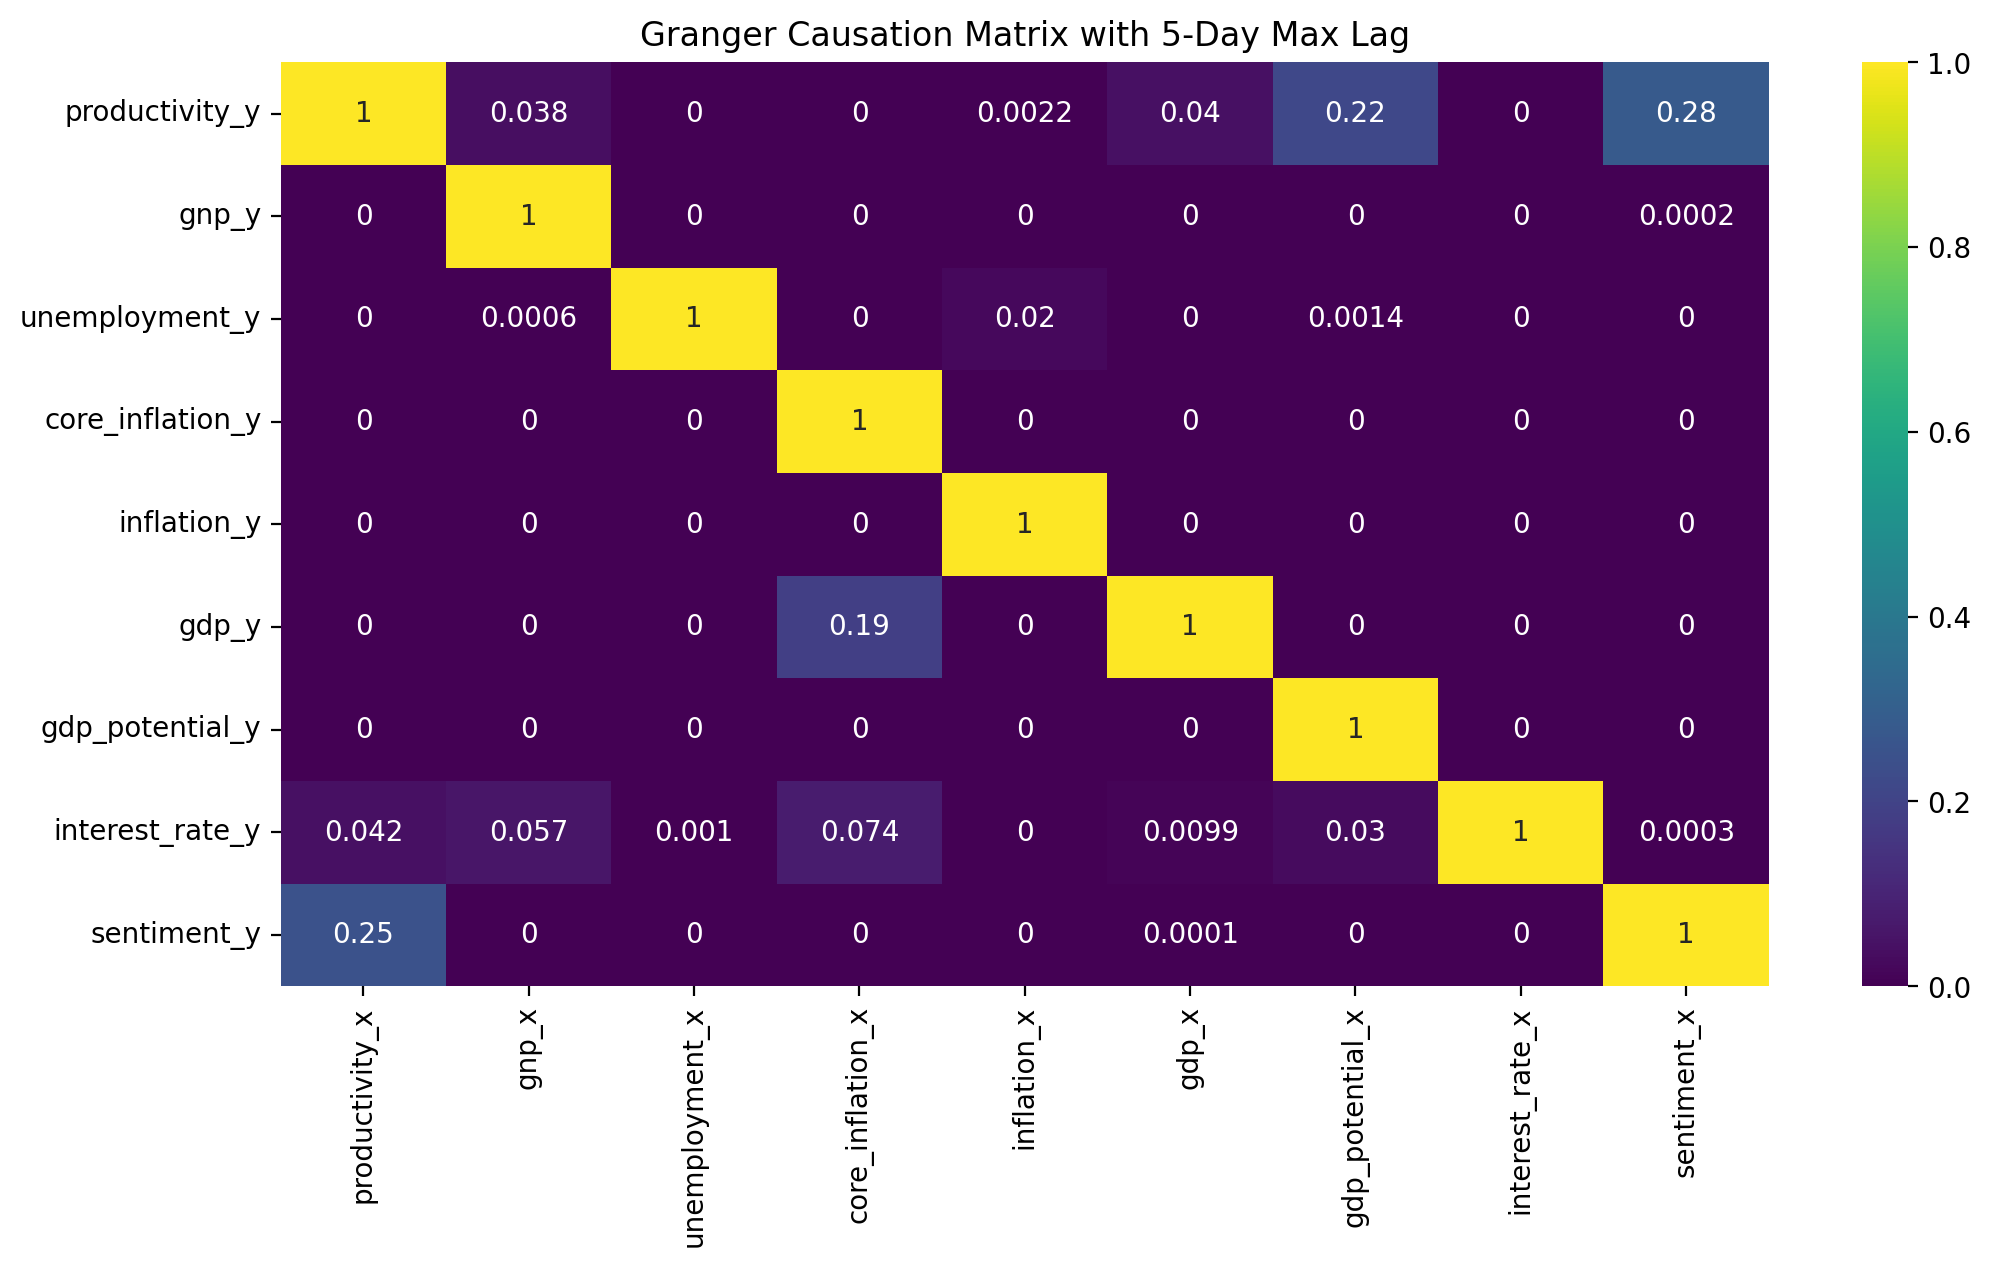

In [15]:
plt.figure(figsize = (12,6), dpi = 200);
sns.heatmap(grangers_causation, annot = True, cmap = 'viridis');
plt.title('Granger Causation Matrix with 5-Day Max Lag');

Variables on the x-axis are being compared as predictors of variables on the y-axis, i.e. past interest rates are not strong predictors of future GDP. However, past GDP has strong predictive power in terms of future in terms of future interest rates. This relationship makes sense - the Federal Reserve will attempt to influence GDP through interest rates, but will ultimately be unable to perfectly contol GDP growth or recession. On the other hand, past GDP performance is a key metric used to guide the Federal Reserve's monetary policy.

All of these interactions have a strong relationship, with a couple of exceptions:

1. Past interest rates and future GDP: This is actually the weakest relationship, despite interest rates being a major means through which the Federal Reserve influences GDP. That said, this is quite a short-term relationship examined here: I selected a max lag of five days. In reality, any change in interest rate policy may take significantly longer than five days to affect the entire US economy and be reflected in GDP.
2. Past core inflation and future GDP: A lot of this is probably down to the fact that GDPPOT is reported quarterly and core inflation monthly, and I linearly imputed both to be on a daily frequency. And again, the lag here is five days - the US GDP won't nescecarily respond linearly and immediately to fluxuations in core inflation.
3. Interest rates and productivity: As mentioned in 01-Data-Cleaning, productive capacity has the potential to near saturation, to the extent that expanding production is often not profitable due to "overproduction and underconsumption", i.e. there is not enough consumer demand to warrant additional capacity. Although this may be reflected by this causation matrix, it is again important to note that this is a five day window being analyzed, and it is unlikely that major changes in the US economy's productive capacity are taking place as a result of changes in interest rates within five days.
4. GDP, Potential GDP and productivity: Again, it is unlikely that productive capacity will massively change within five days. That said, in the event of a recession or a speculative bubble, a large shift in productive capacity could take place in a relatively short amount of time, but this is a fairly uncommon occurance.

## Autocorrelation

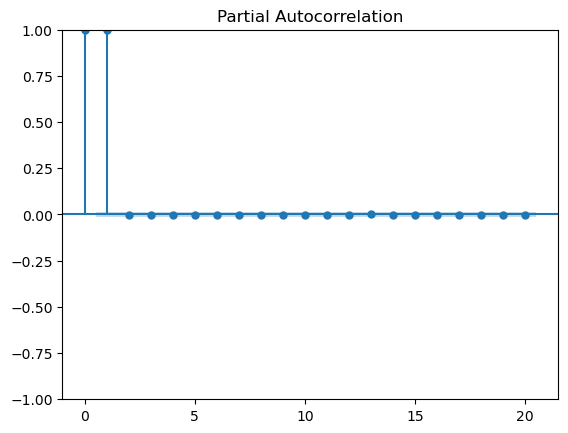

In [28]:
plot_pacf(df['interest_rate'], lags = 20, method = 'ywm');

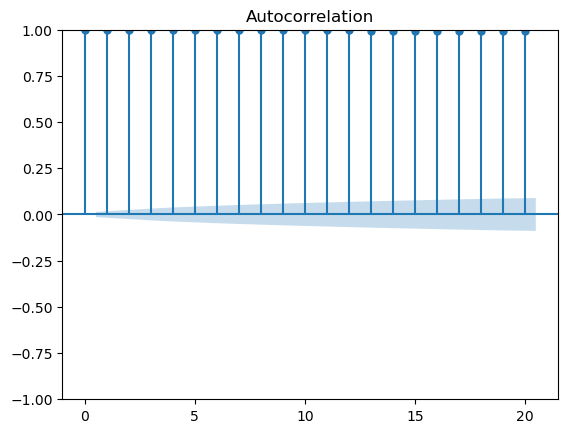

In [29]:
plot_acf(df['interest_rate'], lags = 20);

The first two lags of Partial Autocorrelation have the strongest autocorrelation, so a vector autoregression model with an order of 1 or 2 will probably perform the best. Since this is on a daily frequency, this means that interest rates from yesterday or the day before will have the strongest correlation with today's interest rate. However, this data is on a monthly frequency and has been imputed.